# SF2975 Project 2 Submission by Group 6
Ebba Wallensteen, Pang Jun Rong, Erik Wallin, Axel Jakobsson

We first import the relevant library dependencies for our code. It is highly recommended to use Jupyter Notebook for any interactions with this file, as the matplotlib widget will enable interactive graphs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

plt.rcParams['figure.figsize'] = [8,6]

# (a) Export a continuously compounded zero coupon yield curve y∗(0, T ), boot-strapped from market data of your choice, using the Python notebook. Trans-form the yield curve to a forward rate curve f ∗(0, T ), 0 ≤ T ≤ T ∗. Plot y∗(0, T ),f ∗(0, T ) and p∗(0, T ).

In [2]:
df_ycs = pd.read_csv('yield_curve_spline.csv')
df_ycs.head()

,Date,Yield
0,2023-10-02,0.055240
1,2023-10-03,0.055237
2,2023-10-04,0.055234
3,2023-10-05,0.055231
4,2023-10-06,0.055229


We convert the date column into a date datatype so that graphs can be plotted as a time series.

In [3]:
df_ycs['Date'] = pd.to_datetime(df_ycs['Date'])

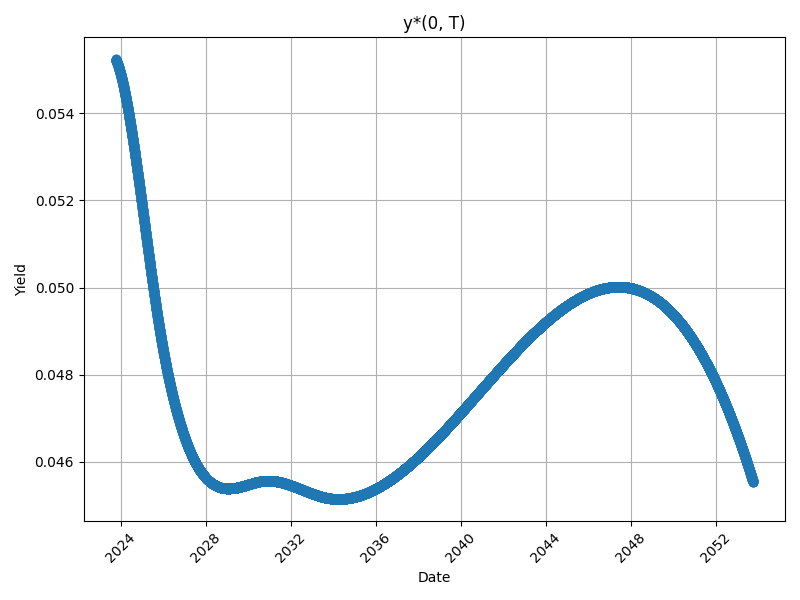

In [4]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['Yield'], marker='o', linestyle='-')
plt.title('y*(0, T)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We calculate maturity in years using the date column. We subsequently calcualte the forward rate using derivatives of both yield and maturity.

In [5]:
df_ycs['Maturity'] = (df_ycs['Date'] - df_ycs['Date'].min()).dt.days / 365.0 # We convert the time difference to a common unit of years
df_ycs['Forward Rate'] = (np.log(df_ycs['Yield']) - np.log(df_ycs['Yield'].shift(1)))/(df_ycs['Maturity'] - df_ycs['Maturity'].shift(1))
df_ycs.head()

,Date,Yield,Maturity,Forward Rate
0,2023-10-02,0.055240,0.000000,NaN
1,2023-10-03,0.055237,0.002740,-0.018940
2,2023-10-04,0.055234,0.005479,-0.019131
3,2023-10-05,0.055231,0.008219,-0.019321
4,2023-10-06,0.055229,0.010959,-0.019510


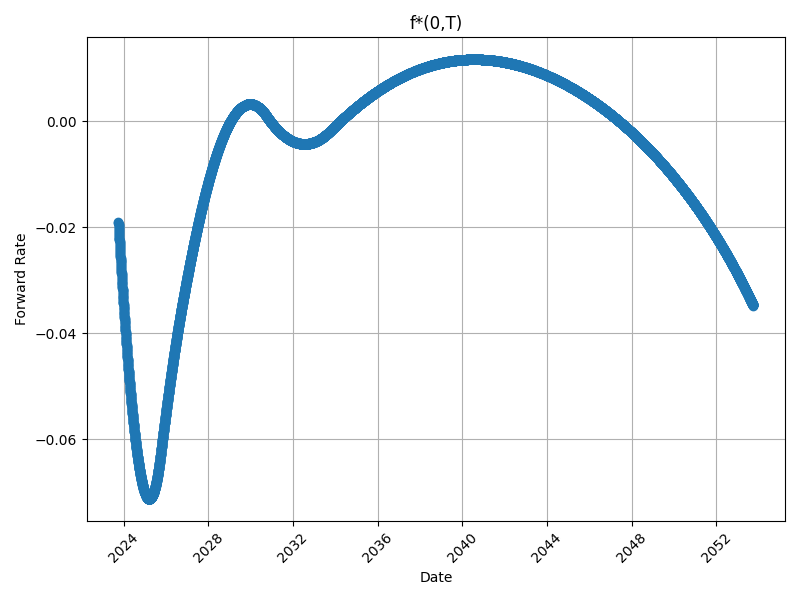

In [6]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['Forward Rate'], marker='o', linestyle='-')
plt.title('f*(0,T)')
plt.xlabel('Date')
plt.ylabel('Forward Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
df_ycs['P*(0, T)'] = np.exp(-df_ycs['Maturity'] * df_ycs['Forward Rate'])

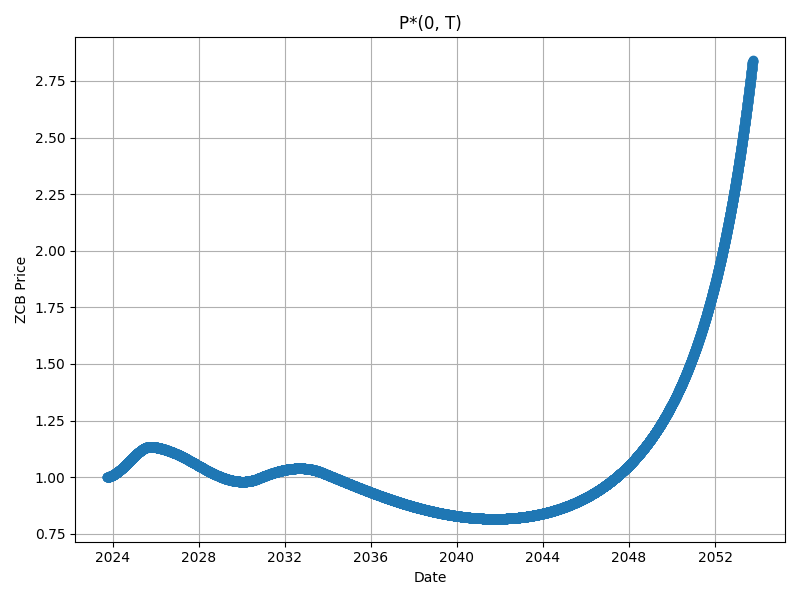

In [8]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['P*(0, T)'], marker='o', linestyle='-', label='P*(0, T)')
plt.title('P*(0, T)')
plt.xlabel('Date')
plt.ylabel('ZCB Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# (b) Express Θ(t) in terms of the forward rate curve and plot it.

In [9]:
# Given by Assignment
alpha = 0.10  # 10%
sigma = 0.01  # 1%

df_ycs['Forward Rate Derivative'] = df_ycs['Forward Rate'].diff()/df_ycs['Maturity'].diff()
df_ycs['Forward Rate Second Derivative'] = df_ycs['Forward Rate Derivative'].diff()/df_ycs['Maturity'].diff()

df_ycs['Theta'] = df_ycs['Forward Rate Derivative'] + sigma**2/alpha * (1-np.exp(-alpha*df_ycs['Maturity']) + alpha*(df_ycs['Forward Rate'] + sigma**2/2*alpha**2)*(1-np.exp(-alpha*df_ycs['Maturity']))**2)

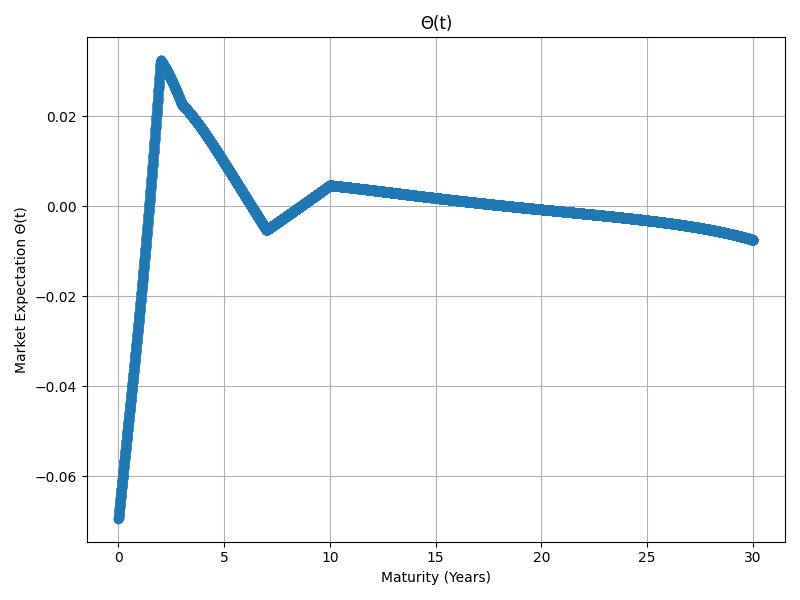

In [10]:
plt.figure()
plt.plot(df_ycs['Maturity'], df_ycs['Theta'], marker='o', linestyle='-')
plt.title('Θ(t)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Market Expectation Θ(t)')
plt.grid(True)
plt.tight_layout()
plt.show()

We drop the first two rows of our data because the forward rate first and second derivative calculations produces a NaN value as a result of using differences. Since the short rate simulation below subsequently uses Euler Discretization Method, we need to ensure that there are no NaN values present in our data.

In [11]:
df_ycs = df_ycs[2:]
df_ycs = df_ycs.reset_index(drop=True)

# (c) Simulate the short rate r(t) and plot it. This means sampling one path of r(t), 0 ≤ t ≤ T ∗, using the Q-dynamics in Equation (1). Add Θ(t)/a to the same plot. How do these relate?

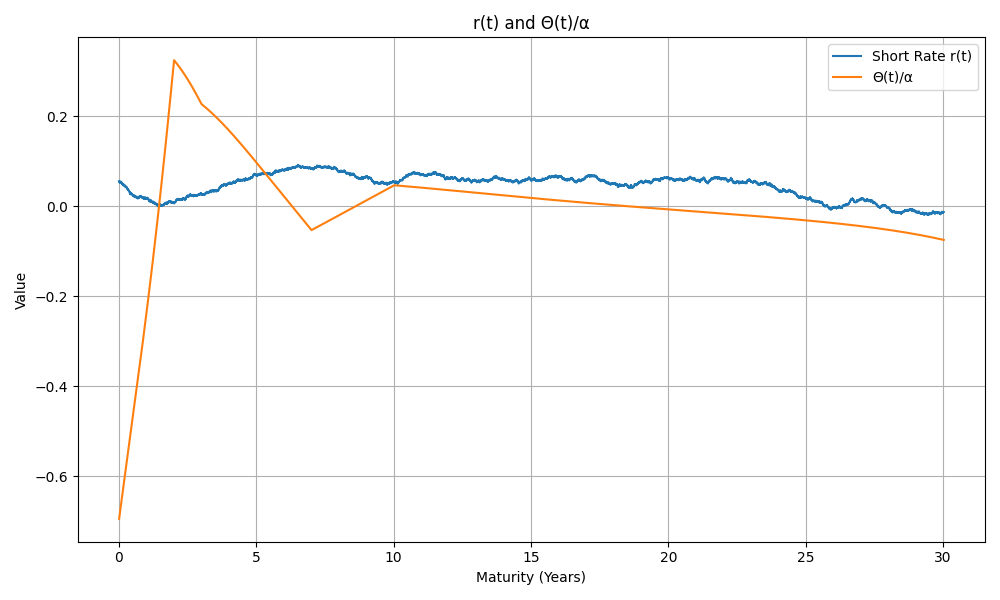

In [12]:
np.random.seed(6)
t_values = df_ycs['Maturity'].values
num_steps = len(t_values)

# Initialize arrays for r(t) and Θ(t)/α
r_values = np.zeros(num_steps)
r_values[0] = df_ycs['Yield'].iloc[0]
theta_values = df_ycs['Theta']/alpha

# Simulate the short rate r(t) and calculate Θ(t)/α
for i in range(num_steps - 1):
    t = t_values[i]
    T = t_values[i + 1]
    
    dt = T - t
    dW = np.random.normal(0, np.sqrt(dt))
    r_values[i + 1] = r_values[i] + (df_ycs['Theta'][i] - alpha * r_values[i]) * dt + sigma * dW
    
# Plot the short rate r(t) and Θ(t)/α
plt.figure(figsize=(10, 6))
plt.plot(t_values, r_values, label='Short Rate r(t)')
plt.plot(t_values, theta_values, label='Θ(t)/α')
plt.title('r(t) and Θ(t)/α')
plt.xlabel('Maturity (Years)')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (e) Use the steps (a)-(c) to calculate the Hull-White term structure p(t, T ∗), i.e., conditioned on your simulated short rate r(t), and plot it.

In [14]:
#Using (21.42)
B_t_T = (1 - np.exp(-alpha * (T - t))) / alpha


In [26]:
#Using (21.50)
#Not sure about calculation of  in P*(0,T)/P*(0,t)
df_ycs['P*(t, T)'] = np.exp(B_t_T*df_ycs['Forward Rate']-(sigma**2/(4*alpha))*B_t_T**2*(1-np.exp(-2*alpha*t))-B_t_T*r_values)

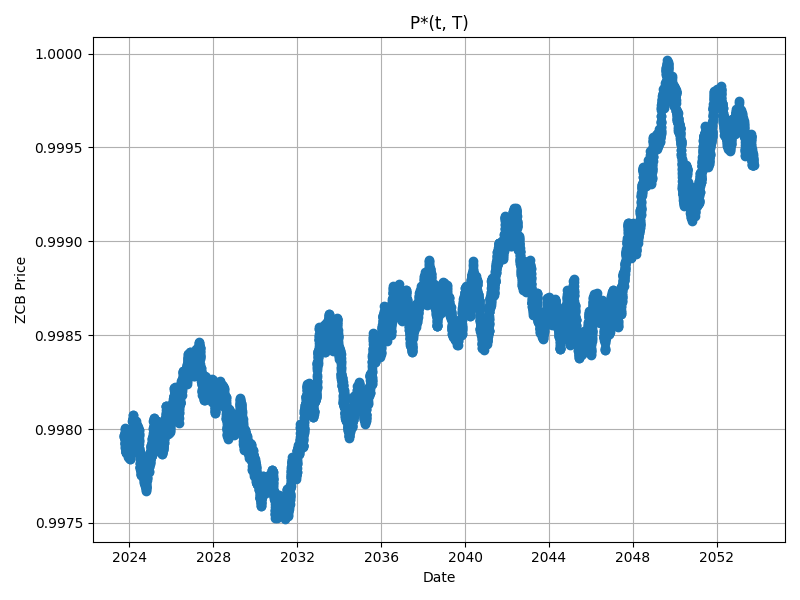

In [27]:
plt.figure()
plt.plot(df_ycs['Date'], df_ycs['P*(t, T)'], marker='o', linestyle='-', label='P*(t, T)')
plt.title('P*(t, T)')
plt.xlabel('Date')
plt.ylabel('ZCB Price')
plt.grid(True)
plt.tight_layout()
plt.show()